In [3]:
#Install the pyspark into the python enivironment and its dependency
!pip install pyspark
!pip install py4j
!pip install findspark
!pip install scikit-learn

In [4]:
#Import necessary libraries
import pyspark
import py4j
import findspark
import os
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from datetime import datetime
from pyspark.sql import functions as F
from pyspark.sql.functions import to_date
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import count
from pyspark.sql.window import Window
from pyspark.sql.functions import sum as fsum
from pyspark.sql.functions import to_date, col, lit, coalesce, current_date, months_between, floor
from pyspark.sql.functions import col, datediff, to_date, year, month, dayofmonth
from pyspark.sql.functions import mean
import pandas as pd
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import RandomForestRegressor
from imblearn.over_sampling import SMOTE
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler, Imputer



# DATA PREPROCESSING


In [5]:
#Initialize a Pyspark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark=SparkSession.builder.appName("Practice").getOrCreate()
spark = SparkSession.builder.appName("PromotionAnalysis").getOrCreate()

In [6]:
#Upload relevant dataset
account_df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/PBD_Dataset/DimAccount.csv', header=True, inferSchema=True)
customer_df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/PBD_Dataset/DimCustomer.csv', header=True, inferSchema=True)
product_df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/PBD_Dataset/DimProduct.csv', header=True, inferSchema=True)
promotion_df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/PBD_Dataset/DimPromotion.csv', header=True, inferSchema=True)
salestarget_df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/PBD_Dataset/FactSalesTargets.csv', header=True, inferSchema=True)
salesterritory_df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/PBD_Dataset/DimSalesTerritory.csv', header=True, inferSchema=True)
date_df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/PBD_Dataset/DimDate.csv', header=True, inferSchema=True)
internetsales_df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/PBD_Dataset/FactInternetSales.csv', header=True, inferSchema=True)
finance_df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/PBD_Dataset/FactFinance.csv', header=True, inferSchema=True)

In [7]:
# Show the structure of each DataFrame
account_df.printSchema()
customer_df.printSchema()
product_df.printSchema()
promotion_df.printSchema()
salestarget_df.printSchema()
salesterritory_df.printSchema()
date_df.printSchema()
internetsales_df.printSchema()
finance_df.printSchema()

root
 |-- AccountKey: integer (nullable = true)
 |-- ParentAccountKey: integer (nullable = true)
 |-- AccountCodeAlternateKey: integer (nullable = true)
 |-- ParentAccountCodeAlternateKey: integer (nullable = true)
 |-- AccountDescription: string (nullable = true)
 |-- AccountType: string (nullable = true)
 |-- Operator: string (nullable = true)
 |-- CustomMembers: string (nullable = true)
 |-- ValueType: string (nullable = true)
 |-- CustomMemberOptions: string (nullable = true)

root
 |-- CustomerKey: integer (nullable = true)
 |-- GeographyKey: integer (nullable = true)
 |-- CustomerAlternateKey: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- FirstName: string (nullable = true)
 |-- MiddleName: string (nullable = true)
 |-- LastName: string (nullable = true)
 |-- NameStyle: boolean (nullable = true)
 |-- BirthDate: date (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- Suffix: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- E

In [8]:
#Show the first five rows of the data
account_df.show(5)
customer_df.show(5)
product_df.show(5)
promotion_df.show(5)
salestarget_df.show(5)
salesterritory_df.show(5)
date_df.show(5)
internetsales_df.show(5)
finance_df.show(5)

+----------+----------------+-----------------------+-----------------------------+------------------+-----------+--------+-------------+---------+-------------------+
|AccountKey|ParentAccountKey|AccountCodeAlternateKey|ParentAccountCodeAlternateKey|AccountDescription|AccountType|Operator|CustomMembers|ValueType|CustomMemberOptions|
+----------+----------------+-----------------------+-----------------------------+------------------+-----------+--------+-------------+---------+-------------------+
|         1|            NULL|                      1|                         NULL|     Balance Sheet|       NULL|       ~|         NULL| Currency|               NULL|
|         2|               1|                     10|                            1|            Assets|     Assets|       +|         NULL| Currency|               NULL|
|         3|               2|                    110|                           10|    Current Assets|     Assets|       +|         NULL| Currency|             

In [9]:
#Checking the summary statistics for numerical columns
account_df.describe().show()
customer_df.describe().show()
product_df.describe().show()
promotion_df.describe().show()
salestarget_df.describe().show()
salesterritory_df.describe().show()
date_df.describe().show()
internetsales_df.describe().show()
finance_df.describe().show()


+-------+------------------+------------------+-----------------------+-----------------------------+------------------+-----------+--------+--------------------+---------+-------------------+
|summary|        AccountKey|  ParentAccountKey|AccountCodeAlternateKey|ParentAccountCodeAlternateKey|AccountDescription|AccountType|Operator|       CustomMembers|ValueType|CustomMemberOptions|
+-------+------------------+------------------+-----------------------+-----------------------------+------------------+-----------+--------+--------------------+---------+-------------------+
|  count|                99|                96|                     99|                           96|                99|         98|      99|                   1|       99|                  0|
|   mean|              51.0|44.114583333333336|      3679.919191919192|           1383.4791666666667|              NULL|       NULL|    NULL|                NULL|     NULL|               NULL|
| stddev|29.172254080945905|27.4766

In [10]:
#Check the type of dataframe
print(f"Type of account_df: {type(account_df)}")
print(f"Type of customer_df: {type(customer_df)}")
print(f"Type of product_df: {type(product_df)}")
print(f"Type of promotion_df: {type(promotion_df)}")
print(f"Type of salestarget_df: {type(salestarget_df)}")
print(f"Type of salesterritory_df: {type(salesterritory_df)}")
print(f"Type of date_df: {type(date_df)}")
print(f"Type of internetsales_df: {type(internetsales_df)}")
print(f"Type of finance_df: {type(finance_df)}")


Type of account_df: <class 'pyspark.sql.dataframe.DataFrame'>
Type of customer_df: <class 'pyspark.sql.dataframe.DataFrame'>
Type of product_df: <class 'pyspark.sql.dataframe.DataFrame'>
Type of promotion_df: <class 'pyspark.sql.dataframe.DataFrame'>
Type of salestarget_df: <class 'pyspark.sql.dataframe.DataFrame'>
Type of salesterritory_df: <class 'pyspark.sql.dataframe.DataFrame'>
Type of date_df: <class 'pyspark.sql.dataframe.DataFrame'>
Type of internetsales_df: <class 'pyspark.sql.dataframe.DataFrame'>
Type of finance_df: <class 'pyspark.sql.dataframe.DataFrame'>


In [11]:
# Define the function to check missing values and show columns
def missing_values(df, df_name):
    # Looping to  each column to check for missing values
    for col_name in df.columns:
        missing_count = df.filter(col(col_name).isNull()).count()
        if missing_count > 0:
            print(f"DataFrame: {df_name} - Column: {col_name} has {missing_count} missing values")
        else:
            print(f"DataFrame: {df_name} - Column: {col_name} has no missing values")

# Check missing values for each dataframe
missing_values(account_df, "account_df")
missing_values(customer_df, "customer_df")
missing_values(product_df, "product_df")
missing_values(promotion_df, "promotion_df")
missing_values(salestarget_df, "salestarget_df")
missing_values(salesterritory_df, "salesterritory_df")
missing_values(date_df, "date_df")
missing_values(internetsales_df, "internetsales_df")
missing_values(finance_df, "finance_df")



DataFrame: account_df - Column: AccountKey has no missing values
DataFrame: account_df - Column: ParentAccountKey has 3 missing values
DataFrame: account_df - Column: AccountCodeAlternateKey has no missing values
DataFrame: account_df - Column: ParentAccountCodeAlternateKey has 3 missing values
DataFrame: account_df - Column: AccountDescription has no missing values
DataFrame: account_df - Column: AccountType has 1 missing values
DataFrame: account_df - Column: Operator has no missing values
DataFrame: account_df - Column: CustomMembers has 98 missing values
DataFrame: account_df - Column: ValueType has no missing values
DataFrame: account_df - Column: CustomMemberOptions has 99 missing values
DataFrame: customer_df - Column: CustomerKey has no missing values
DataFrame: customer_df - Column: GeographyKey has no missing values
DataFrame: customer_df - Column: CustomerAlternateKey has no missing values
DataFrame: customer_df - Column: Title has 18383 missing values
DataFrame: customer_df

In [12]:
# Handling of above missing value by filling the missing value columns in the dataframe with a "0" or "unknown"
account_df = account_df.fillna({
    'ParentAccountKey': 0,
    'ParentAccountCodeAlternateKey': 0,
    'AccountType': 'Unknown',
    'CustomMembers': 'Unknown',
    'CustomMemberOptions': 'Unknown'
})

customer_df = customer_df.fillna({
    'Title': 'Unknown',
    'MiddleName': 'Unknown',
    'Suffix': 'Unknown',
    'AddressLine2': 'Unknown'
})

product_df = product_df.fillna({
    'WeightUnitMeasureCode': 'Unknown',
    'SizeUnitMeasureCode': 'Unknown',
    'SpanishProductName': 'Unknown',
    'FrenchProductName': 'Unknown',
    'StandardCost': 0,
    'ListPrice': 0,
    'Size': 'Unknown',
    'Weight': 0,
    'ProductLine': 'Unknown',
    'DealerPrice': 0,
    'Class': 'Unknown',
    'Style': 'Unknown',
    'ModelName': 'Unknown',
    'EnglishDescription': 'Unknown',
    'EndDate': 'Unknown',
    'Status': 'Unknown'
})



# Impute missing values in numerical columns of promotion_df with the mean
numerical_cols = [col_name for col_name in promotion_df.columns if promotion_df.schema[col_name].dataType
                  in [pyspark.sql.types.IntegerType(), pyspark.sql.types.DoubleType()]]
for col_name in numerical_cols:
    promotion_df = promotion_df.fillna(promotion_df.select(mean(col_name)).collect()[0][0], subset=[col_name])


# Display the first few rows of the imputed promotion_df
promotion_df.show(5)


+------------+---------------------+--------------------+--------------------+--------------------+-----------+--------------------+--------------------+-------------------+------------------------+------------------------+-----------------------+-------------------+-------------------+------+------+
|PromotionKey|PromotionAlternateKey|EnglishPromotionName|SpanishPromotionName| FrenchPromotionName|DiscountPct|EnglishPromotionType|SpanishPromotionType|FrenchPromotionType|EnglishPromotionCategory|SpanishPromotionCategory|FrenchPromotionCategory|          StartDate|            EndDate|MinQty|MaxQty|
+------------+---------------------+--------------------+--------------------+--------------------+-----------+--------------------+--------------------+-------------------+------------------------+------------------------+-----------------------+-------------------+-------------------+------+------+
|           1|                    1|         No Discount|       Sin descuento|       Aucune re

In [13]:
#check if there is still missing values after handling missing value using the missing_values function
missing_values(account_df, 'account_df')
missing_values(customer_df, "customer_df")
missing_values(product_df, "product_df")
missing_values(promotion_df, "promotion_df")
missing_values(salestarget_df, "salestarget_df")
missing_values(salesterritory_df, "salesterritory_df")
missing_values(date_df, "date_df")
missing_values(internetsales_df, "internetsales_df")
missing_values(finance_df, "finance_df")

DataFrame: account_df - Column: AccountKey has no missing values
DataFrame: account_df - Column: ParentAccountKey has no missing values
DataFrame: account_df - Column: AccountCodeAlternateKey has no missing values
DataFrame: account_df - Column: ParentAccountCodeAlternateKey has no missing values
DataFrame: account_df - Column: AccountDescription has no missing values
DataFrame: account_df - Column: AccountType has no missing values
DataFrame: account_df - Column: Operator has no missing values
DataFrame: account_df - Column: CustomMembers has no missing values
DataFrame: account_df - Column: ValueType has no missing values
DataFrame: account_df - Column: CustomMemberOptions has no missing values
DataFrame: customer_df - Column: CustomerKey has no missing values
DataFrame: customer_df - Column: GeographyKey has no missing values
DataFrame: customer_df - Column: CustomerAlternateKey has no missing values
DataFrame: customer_df - Column: Title has no missing values
DataFrame: customer_df

In [14]:
# Checking for duplicates in the dataframes based on all columns
duplicates1 = account_df.groupBy(account_df.columns).count().filter("count > 1")
duplicates2 = customer_df.groupBy(customer_df.columns).count().filter("count > 1")
duplicates3 =product_df.groupBy(product_df.columns).count().filter("count > 1")
duplicates4 = promotion_df.groupBy(promotion_df.columns).count().filter("count > 1")
duplicates5 = salestarget_df.groupBy(salestarget_df.columns).count().filter("count > 1")
duplicates6 = salesterritory_df.groupBy(salesterritory_df.columns).count().filter("count > 1")
duplicates7 = date_df.groupBy(date_df.columns).count().filter("count > 1")
duplicates8 = internetsales_df.groupBy(internetsales_df.columns).count().filter("count > 1")
duplicates9 = finance_df.groupBy(finance_df.columns).count().filter("count > 1")

# show the number of duplicates in each dataframe
duplicates1_count = duplicates1.count()
print(f"Number of duplicate  in Account_df: {duplicates1_count}")

duplicates2_count = duplicates2.count()
print(f"Number of duplicate  in Customer_df: {duplicates2_count}")

duplicates3_count = duplicates3.count()
print(f"Number of duplicate  in Product_df: {duplicates3_count}")


duplicates4_count = duplicates4.count()
print(f"Number of duplicate  in Promotion_df: {duplicates4_count}")

duplicates5_count = duplicates5.count()
print(f"Number of duplicate  in Salestarget_df: {duplicates5_count}")

duplicates6_count = duplicates6.count()
print(f"Number of duplicate  in Salesterritory_df: {duplicates6_count}")

duplicates7_count = duplicates7.count()
print(f"Number of duplicate  in Date_df: {duplicates7_count}")

duplicates8_count = duplicates8.count()
print(f"Number of duplicate  in Internetsales_df: {duplicates8_count}")

duplicates9_count = duplicates9.count()
print(f"Number of duplicate  in Finance_df: {duplicates9_count}")

Number of duplicate  in Account_df: 0
Number of duplicate  in Customer_df: 0
Number of duplicate  in Product_df: 0
Number of duplicate  in Promotion_df: 0
Number of duplicate  in Salestarget_df: 0
Number of duplicate  in Salesterritory_df: 0
Number of duplicate  in Date_df: 0
Number of duplicate  in Internetsales_df: 0
Number of duplicate  in Finance_df: 0


#EXPLORATORY DATA ANALYSIS

---




The uploaded datasets will be joined to ask some data analysis questions in sales/promotion analysis and customer distribution/behaviour analysis and organisation finance analysis










# Customer Demographics Analysis


Question 1. What is the customer age distribution?

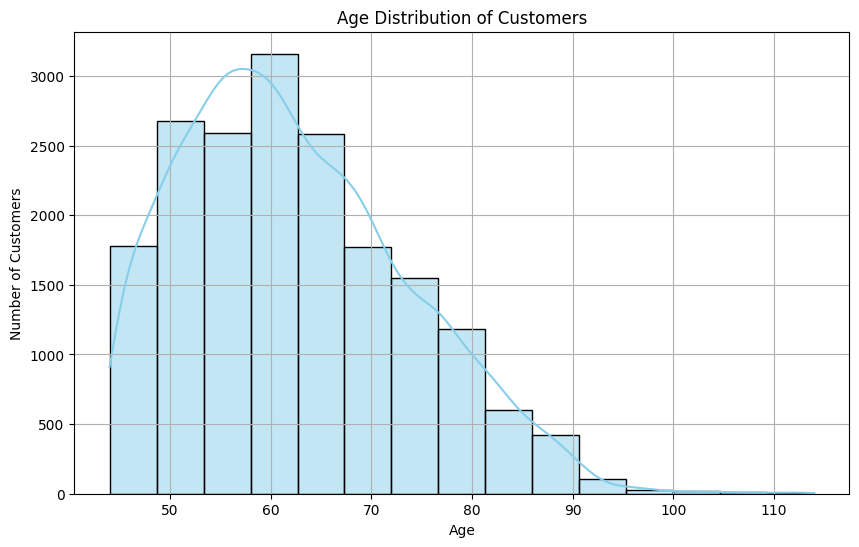

In [15]:
# Convert the 'BirthDate' column to a date format in PySpark
customer_df = customer_df.withColumn('BirthDate', to_date(col('BirthDate'), 'yyyy-MM-dd'))

# Correcting any invalid date formats if any by using 'coalesce' to handle them
customer_df = customer_df.withColumn('BirthDate', coalesce(col('BirthDate'), lit('1900-01-01')))

# Calculating the 'Age' column
customer_df = customer_df.withColumn("Age",  floor(months_between(current_date(), col("BirthDate"))/12))

# Convert the PySpark DataFrame to Pandas for visualization
customer_dfpandas = customer_df.select('Age').toPandas()

# Plot the age distribution using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(customer_dfpandas['Age'], bins=15, kde=True, color='skyblue', edgecolor='black')
plt.title('Age Distribution of Customers')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.show()

Question 2. What is martial status of the customers?

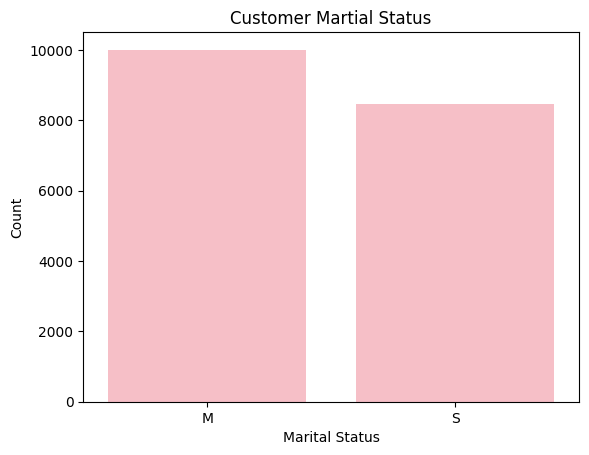

In [16]:
# Converting the PySpark DataFrame to Pandas for visualization, including 'MaritalStatus'
martial_status = customer_df.select('MaritalStatus').toPandas()

# Plotting the martial status distribution
sns.countplot(x='MaritalStatus', data=martial_status, color='lightpink')
plt.title('Customer Martial Status')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.show()


Question 3. What is the customer gender distribution?

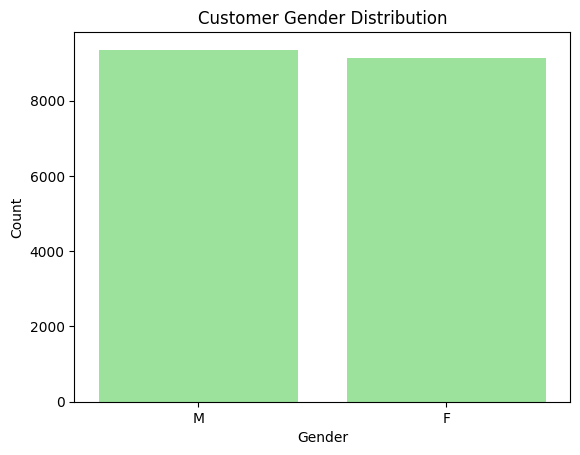

In [17]:
# Showing the customer gender distribution
gender_pd = customer_df.select('Gender').toPandas()

# Plot the gender distribution
sns.countplot(x='Gender', data=gender_pd, color='lightgreen')
plt.title('Customer Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

Question 4. What is the Occupations distribution?


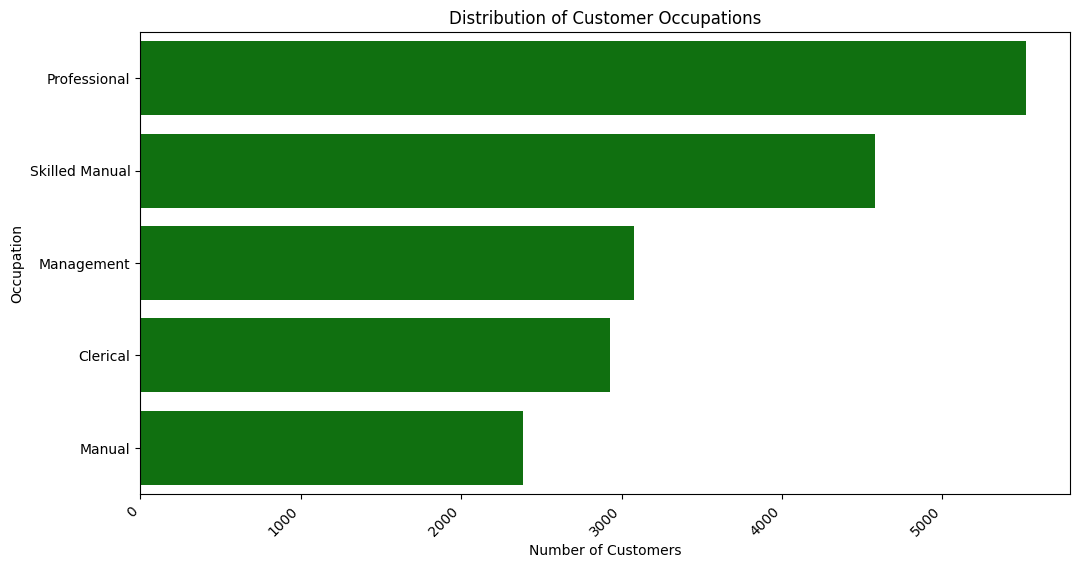

In [18]:
#Convert customer_df to panda to visualise the English Occupation
customer_df_pd = customer_df.select('EnglishOccupation').toPandas()

# Distribution for EnglishOccupation
plt.figure(figsize=(12, 6))
sns.countplot(data=customer_df_pd, y='EnglishOccupation', order=customer_df_pd['EnglishOccupation'].value_counts().index, color='green')
plt.title('Distribution of Customer Occupations')
plt.xlabel('Number of Customers')
plt.ylabel('Occupation')
plt.xticks(rotation=45, ha='right')
plt.show()

Question 5. What is the education distribution?

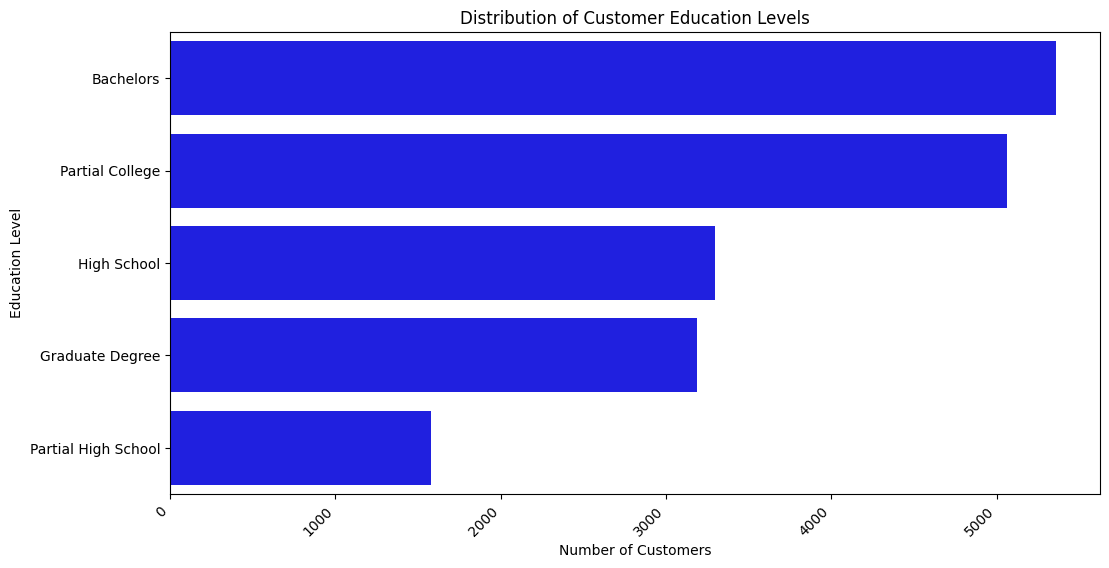

In [19]:
#Convert customer_df to panda to visualise the Customer Education
customer_df_pd = customer_df.select('EnglishEducation').toPandas()

# Distribution of Customer Education
plt.figure(figsize=(12, 6))
sns.countplot(data=customer_df_pd, y='EnglishEducation', order=customer_df_pd['EnglishEducation'].value_counts().index, color='blue')
plt.title('Distribution of Customer Education Levels')
plt.xlabel('Number of Customers')
plt.ylabel('Education Level')
plt.xticks(rotation=45, ha='right')
plt.show()

 Question 6. What is the correlation with yearly income to customer information("NumberCarsOwned", "HouseOwnerFlag", "TotalChildren", "NumberChildrenAtHome")?

Correlation between YearlyIncome and NumberCarsOwned: 0.4666471744182456
Correlation between YearlyIncome and HouseOwnerFlag: 0.04571355822424164
Correlation between YearlyIncome and TotalChildren: 0.21592342695909864
Correlation between YearlyIncome and NumberChildrenAtHome: 0.452133144243324


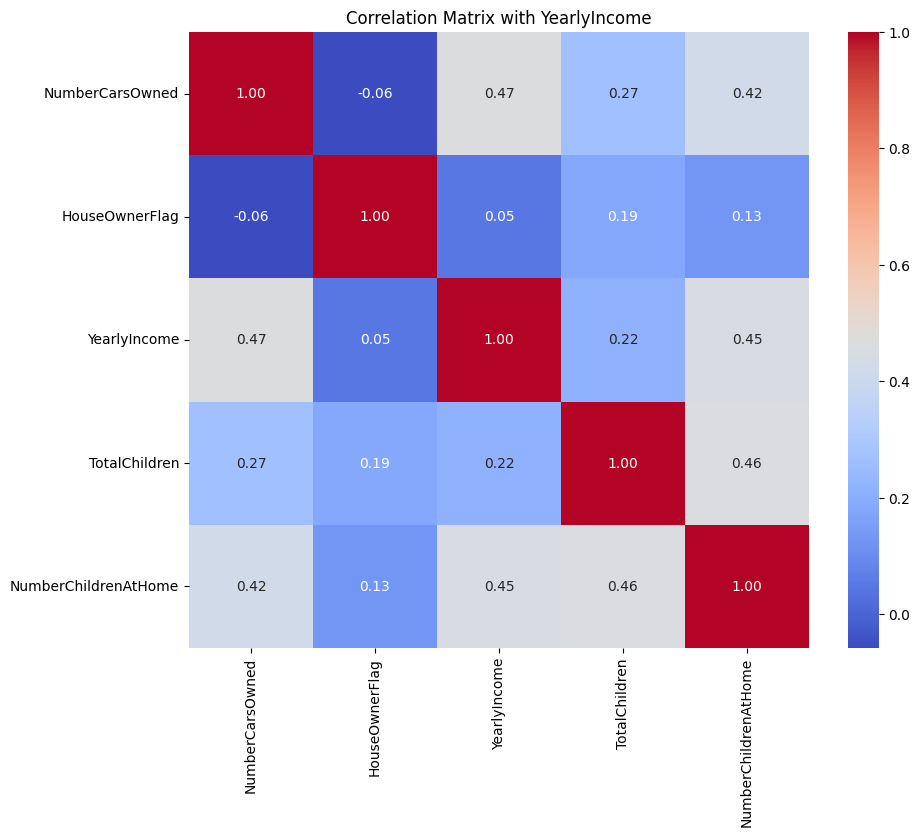

In [20]:

# Selecting relevant columns for the correlation matrix
correlation_data = customer_df.select("NumberCarsOwned", "HouseOwnerFlag", "YearlyIncome", "TotalChildren", "NumberChildrenAtHome")

# Calculate correlations with YearlyIncome using PySpark:
corr_by_yearlyincome = {
    "YearlyIncome_NumberCarsOwned": correlation_data.stat.corr("YearlyIncome", "NumberCarsOwned"),
    "YearlyIncome_HouseOwnerFlag": correlation_data.stat.corr("YearlyIncome", "HouseOwnerFlag"),
    "YearlyIncome_TotalChildren": correlation_data.stat.corr("YearlyIncome", "TotalChildren"),
    "YearlyIncome_NumberChildrenAtHome": correlation_data.stat.corr("YearlyIncome", "NumberChildrenAtHome")
}

# Showing the correlation values of each item
for pair, value in corr_by_yearlyincome.items():
    print(f"Correlation between {pair.replace('_', ' and ')}: {value}")

#  Visualize correlation matrix using Pandas:
correlation_data_pd = correlation_data.toPandas()
correlation_matrix_pd = correlation_data_pd.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_pd, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix with YearlyIncome")
plt.show()

Question 7.	What is the highest yearly income of the customers?

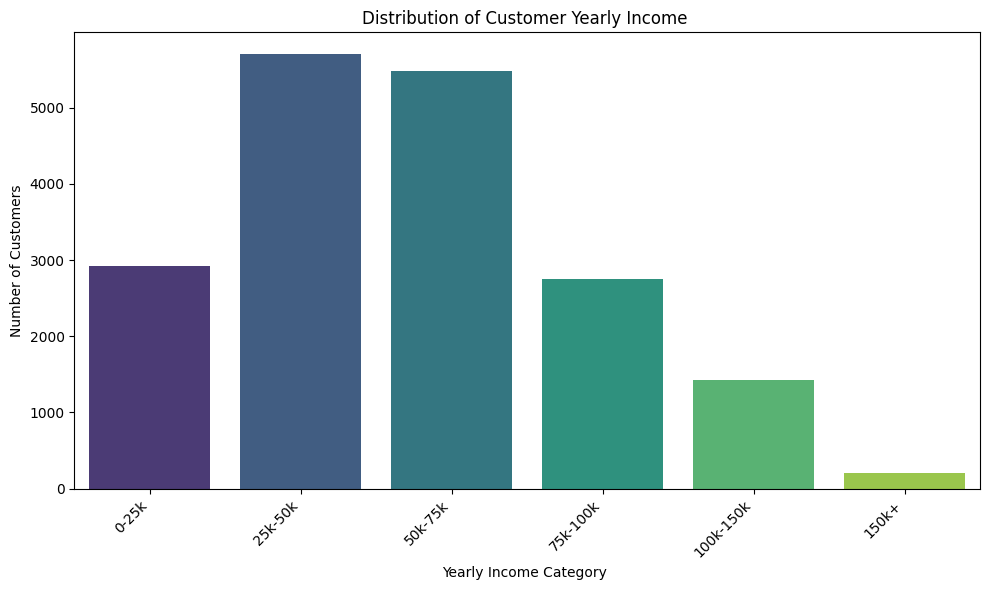

In [21]:
# Convert the PySpark DataFrame to Pandas
customer_df_pd = customer_df.toPandas()

# Defining income bins 0-150 to easily assess the incomes
income_bins = [0, 25000, 50000, 75000, 100000, 150000, np.inf]
income_labels = ['0-25k', '25k-50k', '50k-75k', '75k-100k', '100k-150k', '150k+']

# Create a new column with income categories
customer_df_pd['IncomeCategory'] = pd.cut(customer_df_pd['YearlyIncome'], bins=income_bins, labels=income_labels, include_lowest=True)

# Create the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=customer_df_pd, x='IncomeCategory', hue='IncomeCategory', palette='viridis', dodge=False, legend=False)

plt.title('Distribution of Customer Yearly Income ')
plt.xlabel('Yearly Income Category ')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Sales and Promotion Analysis


Question 8: What are the highest sales made by each region?

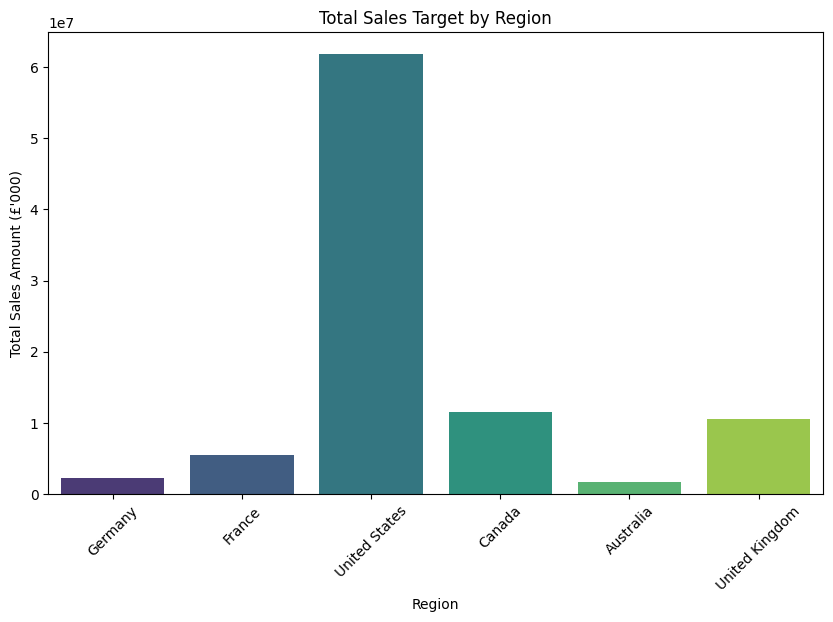

In [22]:
# Joining SalesTargets_df and SalesTerritory_df to get Sales Performance by Region
sales_by_region = salestarget_df.join(salesterritory_df,
                                                 salestarget_df["SalesTerritoryKey"] == salesterritory_df["SalesTerritoryKey"],
                                                 "inner")

# Calculate total sales target by region
# Specify the DataFrame for SalesTerritoryRegion
totalsales_by_region = sales_by_region.groupBy(salesterritory_df["SalesTerritoryCountry"]) \
                                           .agg({"SalesAmountQuote": "sum"}) \
                                           .withColumnRenamed("sum(SalesAmountQuote)", "TotalSalesAmountQuote")




# Convert the PySpark DataFrame to Pandas before plotting
totalsales_by_region_pd = totalsales_by_region.toPandas()

#plotting total sales target by region
plt.figure(figsize=(10, 6))
sns.barplot(x='SalesTerritoryCountry', y='TotalSalesAmountQuote',
            data=totalsales_by_region_pd, hue='SalesTerritoryCountry', palette="viridis", legend=False)
plt.title('Total Sales Target by Region')
plt.xticks(rotation=45)
plt.xlabel('Region')
plt.ylabel('Total Sales Amount (£\'000)')
plt.show()



Question 9.	What are the highest yearly sales?

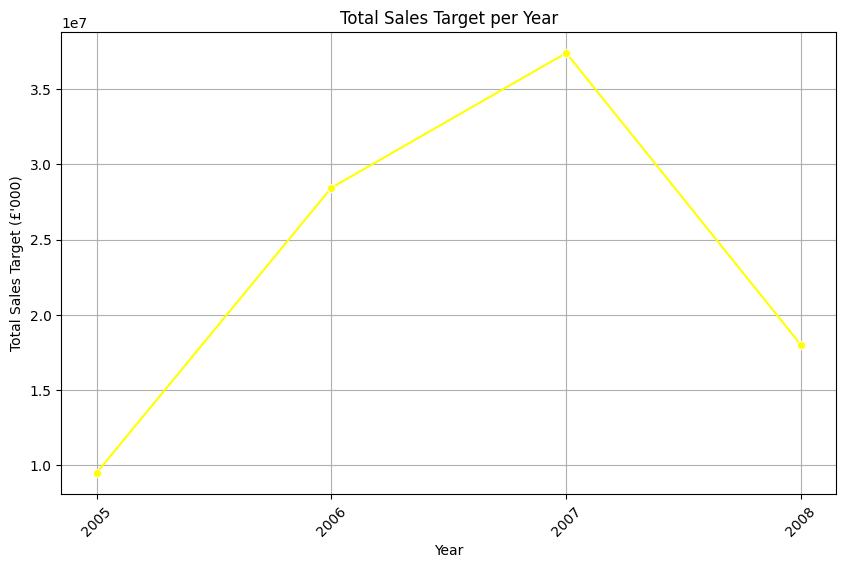

In [23]:

# Group the calendar year and sum the sales target, accessing the sales data using 'salesamountquote'
yearly_sales = sales_by_region.groupBy('CalendarYear').agg({'SalesAmountQuote': 'sum'}).toPandas()

#Creating and naming the sum of the sales amount quote colunm.
yearly_sales = yearly_sales.rename(columns={'sum(SalesAmountQuote)': 'SalesAmountQuote'})

# Visualize the yearly sales target trends
plt.figure(figsize=(10, 6))
sns.lineplot(x='CalendarYear', y='SalesAmountQuote', data=yearly_sales, marker='o', color='yellow')
plt.title('Total Sales Target per Year')
plt.xlabel('Year')
plt.ylabel('Total Sales Target (£\'000)')
plt.xticks(rotation=45)
plt.grid(True)

# Get the current axes
ax = plt.gca()
# Remove decimal points from year values
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

plt.show()

Question 10. What is the customer retention rate and average customer retention days?

+----------------------+-------------+-------------------+------------------+
|DaysSinceFirstPurchase|CustomerCount|CumulativeCustomers|     RetentionRate|
+----------------------+-------------+-------------------+------------------+
|                  2007|        36720|              36720| 60.79671512301732|
|                  2008|           27|              36747|60.841418590019536|
|                  2009|           38|              36785| 60.90433458061525|
|                  2010|           21|              36806|  60.9391039438392|
|                  2011|           26|              36832| 60.98215172687838|
|                  2012|           17|              36849| 61.01029835425014|
|                  2013|           25|              36874|61.051690453326266|
|                  2014|           26|              36900|61.094738236365444|
|                  2015|           30|              36930|  61.1444087552568|
|                  2016|           40|              36970|61.210

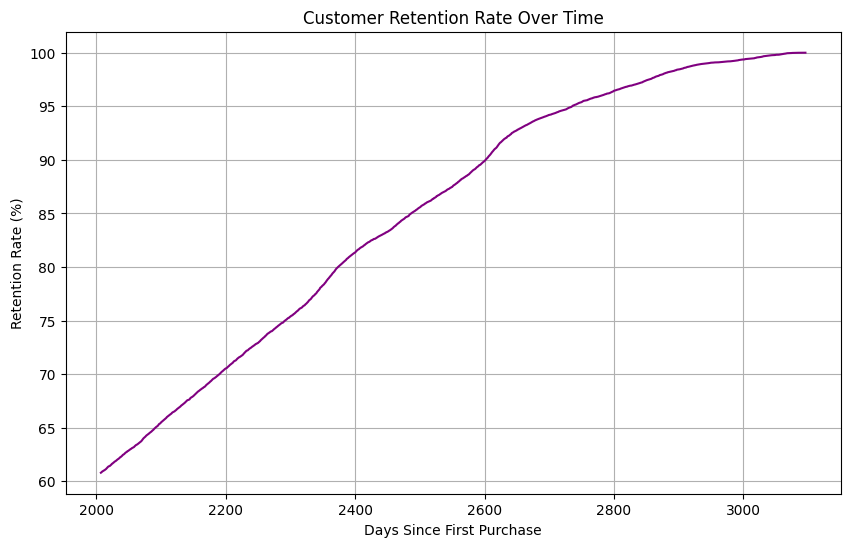

In [24]:

# Joining the Customer_df and InternetSales_df  on CustomerKey
customer_retention = customer_df.join(internetsales_df, on='CustomerKey', how='inner')

# Convert DateFirstPurchase and OrderDate to date type
customer_retention = customer_retention.withColumn('DateFirstPurchase', to_date(col('DateFirstPurchase'), 'yyyy-MM-dd'))
customer_retention= customer_retention.withColumn('OrderDate', to_date(col('OrderDate'), 'yyyy-MM-dd'))

# Calculate the difference in days between OrderDate and DateFirstPurchase
customer_retention = customer_retention.withColumn('DaysSinceFirstPurchase', datediff(col('OrderDate'), col('DateFirstPurchase')))

# Group by DaysSinceFirstPurchase and count the number of customers
retention_df = customer_retention.groupBy('DaysSinceFirstPurchase').agg(count('*').alias('CustomerCount'))

# Calculate the cumulative sum of customers
retention_df = retention_df.withColumn('CumulativeCustomers', fsum('CustomerCount').over(Window.orderBy('DaysSinceFirstPurchase')))


# Calculate the total number of customers
total_customers = retention_df.agg({'CustomerCount': 'sum'}).collect()[0][0]

# Calculate the retention rate
retention_df = retention_df.withColumn('RetentionRate', (col('CumulativeCustomers') / total_customers) * 100)

#Printing the Retention Rate
retention_df.show()

# Calculate the average retention rate
avgretention_rate = retention_df.select(mean("RetentionRate")).collect()[0][0]

print(f"Average Retention Rate: {avgretention_rate:.2f}%")
# Convert to Pandas DataFrame for plotting
retention_df= retention_df.toPandas()

# Plotting the Retention Rate using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='DaysSinceFirstPurchase', y='RetentionRate', data=retention_df, color='purple')
plt.title('Customer Retention Rate Over Time')
plt.xlabel('Days Since First Purchase')
plt.ylabel('Retention Rate (%)')
plt.grid(True)
plt.show()

In [25]:
# Joining Customer_df with InternetSales_df using the CustomerKey
customer_retention = customer_df.join(internetsales_df, customer_df["CustomerKey"] == internetsales_df["CustomerKey"], "inner")

# Create a new column 'OldCustomer' using the 'DateFirstPurchase' field from DimCustomer
customer_retention = customer_retention.withColumn("OldCustomer", to_date(customer_df["DateFirstPurchase"], "yyyy-MM-dd"))

# Use 'ShipDate' from InternetSales_df to calculate 'DaysSinceFirstPurchase'
customer_retention = customer_retention.withColumn("ShipDate", to_date(internetsales_df["ShipDate"], "yyyy-MM-dd"))

# Calculate 'DaysSinceFirstPurchase' by finding the difference between the ShipDate and the DateFirstPurchase
customer_retention = customer_retention.withColumn("DaysSinceFirstPurchase", datediff(customer_retention["ShipDate"], customer_retention["OldCustomer"]))


# Calculate the average retention period
avg_retention = customer_retention.agg({"DaysSinceFirstPurchase": "avg"}).withColumnRenamed("avg(DaysSinceFirstPurchase)", "AvgRetentionDays")

# Show the result
avg_retention.show()


+-----------------+
| AvgRetentionDays|
+-----------------+
|2174.138199940395|
+-----------------+



Question 11. What is the customer conversion rate and average days to convert a customer?

+----------------------+-------------+-------------------+------------------+
|DaysSinceFirstPurchase|CustomerCount|CumulativeCustomers|    ConversionRate|
+----------------------+-------------+-------------------+------------------+
|                  2007|        36720|              36720| 60.79671512301732|
|                  2008|           27|              36747|60.841418590019536|
|                  2009|           38|              36785| 60.90433458061525|
|                  2010|           21|              36806|  60.9391039438392|
|                  2011|           26|              36832| 60.98215172687838|
|                  2012|           17|              36849| 61.01029835425014|
|                  2013|           25|              36874|61.051690453326266|
|                  2014|           26|              36900|61.094738236365444|
|                  2015|           30|              36930|  61.1444087552568|
|                  2016|           40|              36970|61.210

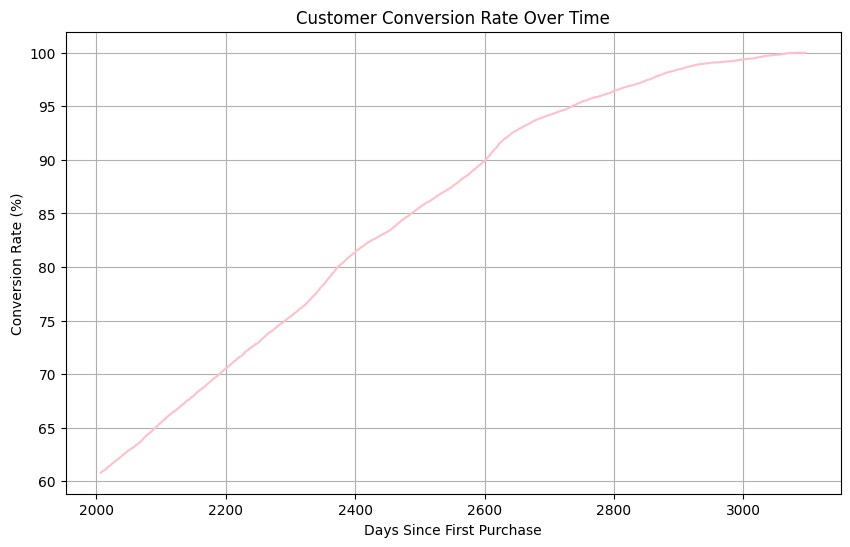

In [26]:
# Join customer_df and internetsales_df on CustomerKey
customer_conversion = customer_df.join(internetsales_df, on='CustomerKey', how='inner')

# Convert DateFirstPurchase and OrderDate to date type
customer_conversion = customer_conversion.withColumn('DateFirstPurchase', to_date(col('DateFirstPurchase'), 'yyyy-MM-dd'))
customer_conversion = customer_conversion.withColumn('OrderDate', to_date(col('OrderDate'), 'yyyy-MM-dd'))

# Calculate the difference in days between OrderDate and DateFirstPurchase
customer_conversion = customer_conversion.withColumn('DaysSinceFirstPurchase', datediff(col('OrderDate'), col('DateFirstPurchase')))

# Group by DaysSinceFirstPurchase and count the number of customers
conversion_df = customer_conversion.groupBy('DaysSinceFirstPurchase').agg(count('*').alias('CustomerCount'))

# Calculate the cumulative sum of customers
conversion_df = conversion_df.withColumn('CumulativeCustomers', fsum('CustomerCount').over(Window.orderBy('DaysSinceFirstPurchase')))

# Calculate the total number of customers
total_customers = conversion_df.agg({'CustomerCount': 'sum'}).collect()[0][0]

# Calculate the conversion rate
conversion_df = conversion_df.withColumn('ConversionRate', (col('CumulativeCustomers') / total_customers) * 100)

#printing the conversion rate
conversion_df.show()

# Convert to Pandas DataFrame for plotting
conversion_pd = conversion_df.toPandas()

# Calculate the average conversion rate
avgconversion_rate = conversion_df.select(mean("ConversionRate")).collect()[0][0]

print(f"Average Conversion Rate: {avgconversion_rate:.2f}%")

# Plotting the Conversion Rate using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='DaysSinceFirstPurchase', y='ConversionRate', data=conversion_pd, color='pink')
plt.title('Customer Conversion Rate Over Time')
plt.xlabel('Days Since First Purchase')
plt.ylabel('Conversion Rate (%)')
plt.grid(True)
plt.show()

In [27]:
# Joining Customer_df with InternetSales_df using the CustomerKey
purchase_behavior = customer_df.join(internetsales_df, customer_df["CustomerKey"] == internetsales_df["CustomerKey"], "inner")

# Create a new column 'FirstPurchaseDate' from the 'DateFirstPurchase' field from DimCustomer
purchase_behavior = purchase_behavior.withColumn("FirstPurchaseDate", to_date(customer_df["DateFirstPurchase"], "yyyy-MM-dd"))

# Use 'ShipDate' from InternetSales_df to calculate the days since the first purchase
purchase_behavior = purchase_behavior.withColumn("OrderDate", to_date(internetsales_df["OrderDate"], "yyyy-MM-dd"))

# Calculate 'DaysToFirstPurchase' by finding the difference between the ShipDate and the DateFirstPurchase
purchase_behavior = purchase_behavior.withColumn("DaysToFirstPurchase", datediff(purchase_behavior["OrderDate"], purchase_behavior["FirstPurchaseDate"]))

# Calculate the average days to first purchase
averagedays_to_purchase = purchase_behavior.agg({"DaysToFirstPurchase": "avg"}).withColumnRenamed("avg(DaysToFirstPurchase)", "AvgDaysToPurchase")

# Show the result for average days to first purchase
averagedays_to_purchase.show()

+-----------------+
|AvgDaysToPurchase|
+-----------------+
|2167.138199940395|
+-----------------+



 What is the correlation between the number of cars owned and house ownership status to customer purchase behaviour?

Correlation between Number of Cars Owned and House Ownership: -0.07495536059852986


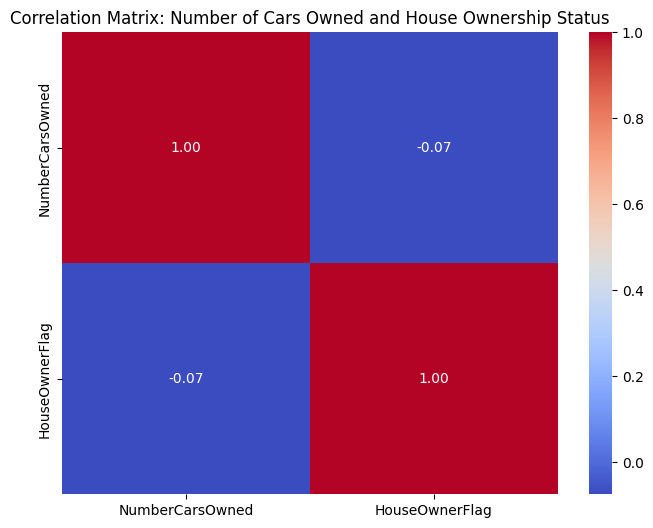

In [28]:
# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
purchase_behavior_pd = purchase_behavior.toPandas()


# Accessing the relevant columns (NumberCarsOwned, HouseOwnerFlag)
purchase_behavior = purchase_behavior.select("NumberCarsOwned", "HouseOwnerFlag")

# Show the correlation between NumberCarsOwned and HouseOwnerFlag
HouseVsCar_correlation = purchase_behavior.corr("NumberCarsOwned", "HouseOwnerFlag")
print(f"Correlation between Number of Cars Owned and House Ownership: {HouseVsCar_correlation}")

# Select relevant columns for the correlation matrix
correlation_data = purchase_behavior.select("NumberCarsOwned", "HouseOwnerFlag",).toPandas()

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix: Number of Cars Owned and House Ownership Status")
plt.show()

Question 12.	What are the total sales by age group?

In [29]:
# Converting the 'BirthDate' column to a date format in PySpark to get the age per customer
customer_df = customer_df.withColumn('BirthDate', to_date(col('BirthDate'), 'yyyy-MM-dd'))

# Calculate Age by subtracting the year of BirthDate from the current year
current_year = datetime.now().year
customer_df = customer_df.withColumn("Age",  lit(current_year) - year(col("BirthDate")))

# Display the first few rows to verify the 'Age' column
customer_df[['CustomerKey', 'BirthDate', 'Age']].show(5)

+-----------+----------+---+
|CustomerKey| BirthDate|Age|
+-----------+----------+---+
|      11000|1966-04-08| 59|
|      11001|1965-05-14| 60|
|      11002|1965-08-12| 60|
|      11003|1968-02-15| 57|
|      11004|1968-08-08| 57|
+-----------+----------+---+
only showing top 5 rows



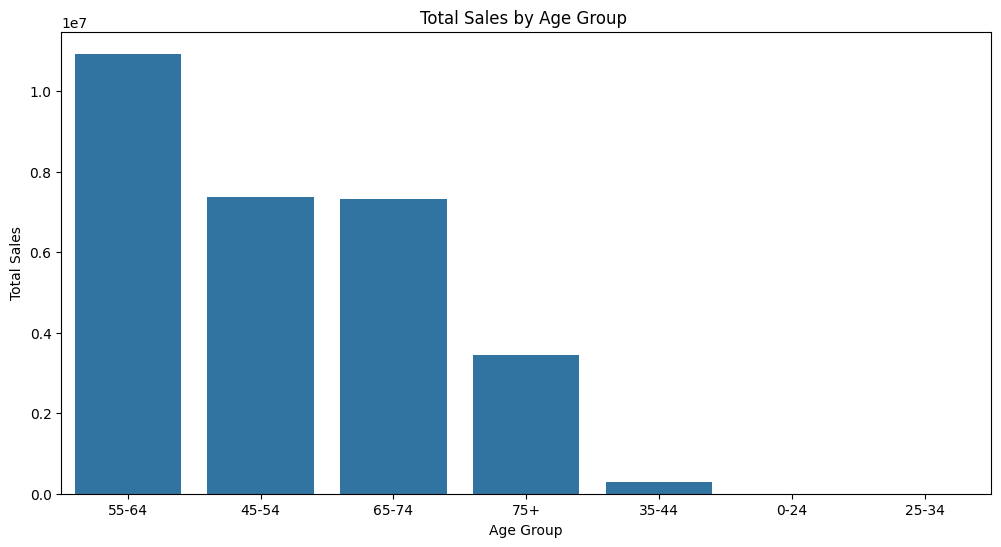

,Age,TotalSales,AgeGroup
0,79,3578.2700,75+
1,61,3399.9900,55-64
2,79,3399.9900,75+
3,87,699.0982,75+
4,57,3399.9900,55-64
5,64,3578.2700,55-64
6,53,3578.2700,45-54
7,60,3374.9900,55-64
8,62,3399.9900,55-64
9,61,3578.2700,55-64


In [30]:
# Joining the internetsales_df and customer_df on CustomerKey
sales_by_age = customer_df.join(internetsales_df, customer_df["CustomerKey"] == internetsales_df["CustomerKey"], "inner")

# Including the 'Age' column into sales_by_age DataFrame and select it
sales_by_age = sales_by_age.select(customer_df["Age"], internetsales_df["SalesAmount"])

# Rename the 'SalesAmount' column to 'TotalSales'
sales_by_age = sales_by_age.withColumnRenamed("SalesAmount", "TotalSales")

# Convert to Pandas for plotting
sales_by_agepd = sales_by_age.toPandas()

# Filter out ages above a reasonable threshold (e.g., 100)
sales_by_agepd = sales_by_agepd[sales_by_agepd['Age'] <= 100]

# Define age bins and labels
age_bins = [0, 25, 35, 45, 55, 65, 75, 100]
age_labels = ['0-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']

# Create a new column with age group categories
sales_by_agepd['AgeGroup'] = pd.cut(sales_by_agepd['Age'], bins=age_bins, labels=age_labels)

# Group by age group and sum total sales (using Pandas groupby), setting observed=False to retain current behavior
sales_by_age_group = sales_by_agepd.groupby('AgeGroup', observed=False)['TotalSales'].sum().reset_index()

# Sort by total sales in descending order
sales_by_age_group = sales_by_age_group.sort_values('TotalSales', ascending=False)

# Plotting the results
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='AgeGroup', y='TotalSales', data=sales_by_age_group, order=sales_by_age_group['AgeGroup'])

plt.title('Total Sales by Age Group ')
plt.xlabel('Age Group')
plt.ylabel('Total Sales')
plt.show()

sales_by_agepd.head(10)

Question 13. What is the average product promotion duration?

In [31]:
# Joining  Promotion_df and InternetSales_df to get the promotion duration
promotion_duration = promotion_df.join(internetsales_df, promotion_df["PromotionKey"] == internetsales_df["PromotionKey"], "inner")

#choosing the end date and start date column for the promotion duration
promotion_duration = promotion_duration.withColumn("PromotionDuration", datediff(to_date(promotion_df["EndDate"], "yyyy-MM-dd"),
                                                                                 to_date(promotion_df["StartDate"], "yyyy-MM-dd")))

# Convert to Pandas DataFrame for plotting, include "PromotionKey and pick which 'PromotionKey' to select using alias
promotion_durationpd = promotion_duration.select(promotion_df["PromotionKey"].alias("PromotionKey"), "PromotionDuration").toPandas()

# Group by PromotionKey and get the average duration
average_duration = promotion_durationpd.groupby("PromotionKey")["PromotionDuration"].mean().reset_index()

average_duration.head()

,PromotionKey,PromotionDuration
0,1,1309.0
1,2,1095.0
2,13,91.0
3,14,91.0


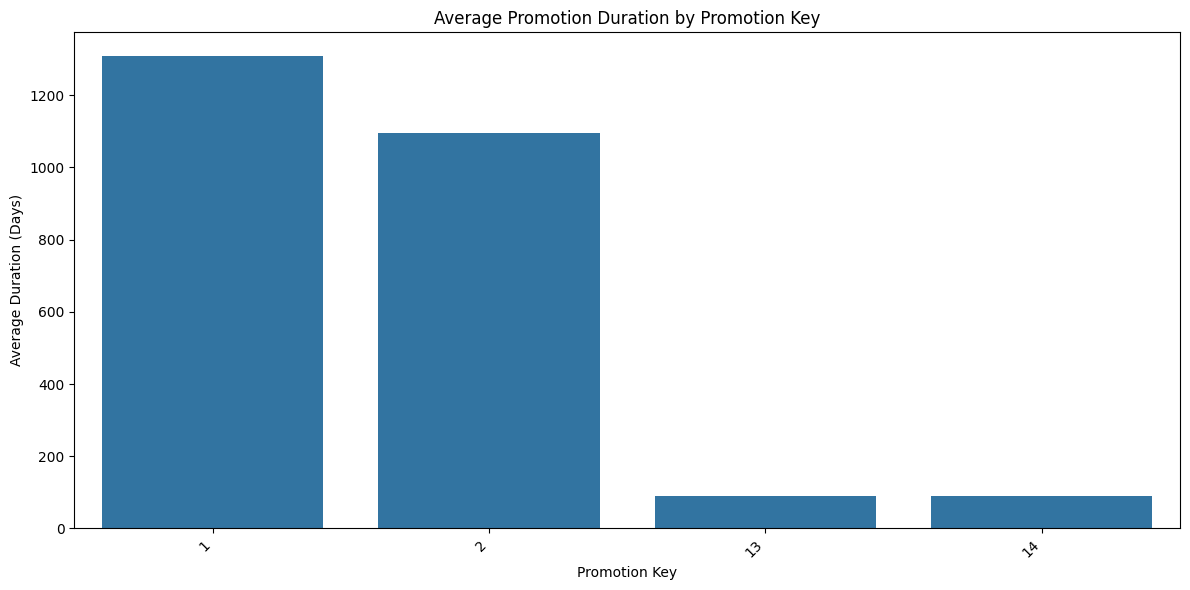

In [32]:

# Plot using seaborn barplot
plt.figure(figsize=(12, 6))
sns.barplot(x="PromotionKey", y="PromotionDuration", data=average_duration)
plt.title("Average Promotion Duration by Promotion Key")
plt.xlabel("Promotion Key")
plt.ylabel("Average Duration (Days)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Question 14. What type of promotion categories does the business have?

In [34]:
# Identify  the promotion categories
promotion_types = promotion_df.groupBy("EnglishPromotionType").count().orderBy("count", ascending=False).toPandas()
promotion_types.columns = ['PromotionType', 'Count']

# Calculate the average discount percentage across all promotions and identify  the promotion categories
promotion_types = promotion_df.groupBy("EnglishPromotionType").count().orderBy("count", ascending=False).toPandas()
promotion_types.columns = ['PromotionType', 'Count']

# Calculate the average discount percentage across all promotions
average_discount = promotion_df.select(F.mean("DiscountPct")).collect()[0][0]

print('Average Discount:', average_discount)

Average Discount: 0.22


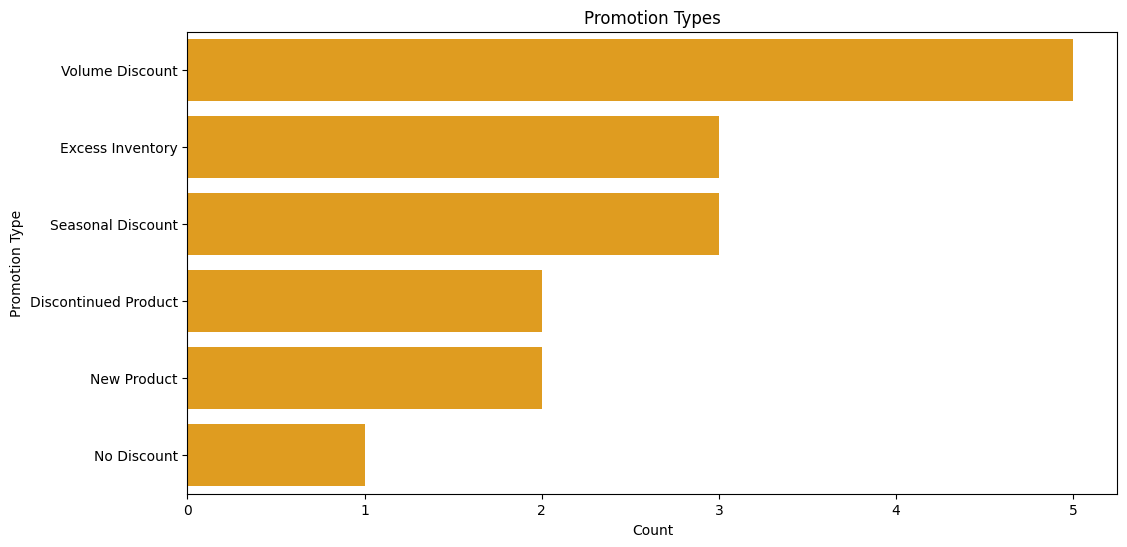

In [35]:
# Visualize the common promotion types
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='PromotionType', data=promotion_types, color='orange')
plt.title('Promotion Types')
plt.xlabel('Count')
plt.ylabel('Promotion Type')
plt.show()

Question 15. What month has the highest promotion?

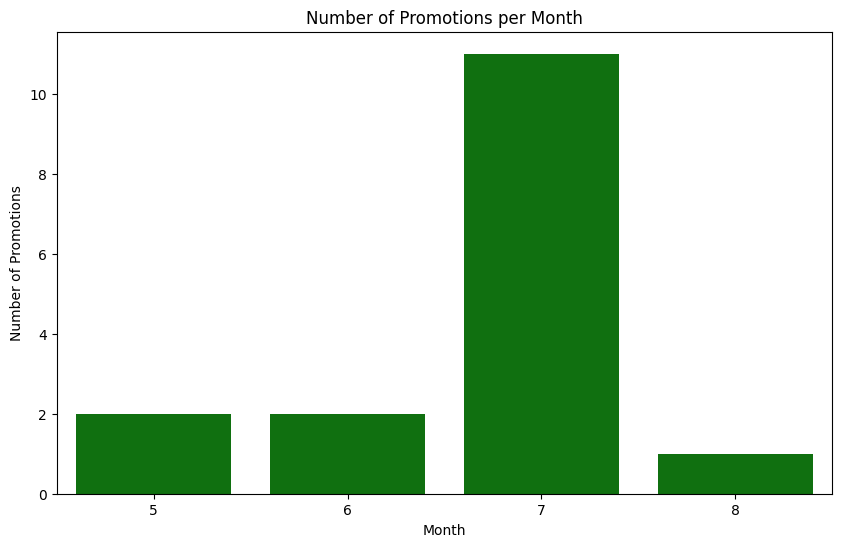

In [36]:
# Joining  Promotion_df and InternetSales_df to get the promotion timing
promotion_time = promotion_df.withColumn("StartMonth", month(to_date(promotion_df["StartDate"], "yyyy-MM-dd"))) \
                                .groupBy("StartMonth").agg({"PromotionKey": "count"}).withColumnRenamed("count(PromotionKey)", "PromotionCount")

# Promotion Timing (Promotions by Month)
promotion_timepd = promotion_time.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(x='StartMonth', y='PromotionCount', data=promotion_timepd, color='green')
plt.title('Number of Promotions per Month')
plt.xlabel('Month')
plt.ylabel('Number of Promotions')
plt.show()

# Finance Analysis

Question 16. What is account distribution types?

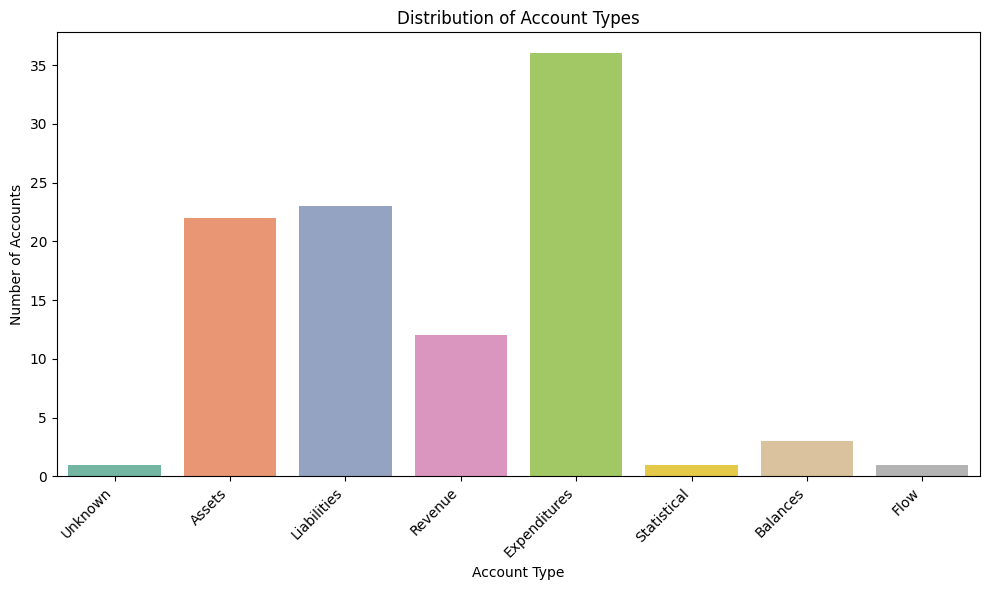

In [37]:

# Convert the PySpark DataFrame to Pandas
account_df_pd = account_df.toPandas()

# Create the countplot using Seaborn with 'Set2' palette
plt.figure(figsize=(10, 6))
sns.countplot(data=account_df_pd, x='AccountType', hue='AccountType', palette='Set2', dodge=False, legend=False)

plt.title('Distribution of Account Types')
plt.xlabel('Account Type')
plt.ylabel('Number of Accounts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Question 17. What is the average amount in the account types?

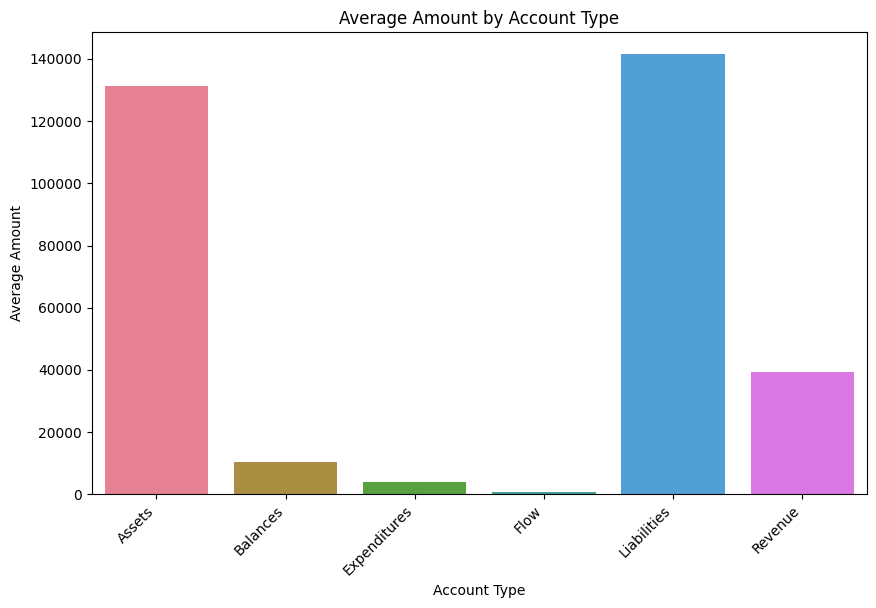

In [38]:

# Convert PySpark DataFrames to Pandas
account_df_pd = account_df.toPandas()
finance_df_pd = finance_df.toPandas()

# Merging the DataFrames using the 'AccountKey'
merged_df = pd.merge(account_df_pd[['AccountKey', 'AccountType']], finance_df_pd[['AccountKey', 'Amount']], on='AccountKey', how='inner')

# Calculate the average amount for each account type
average_amount = merged_df.groupby('AccountType')['Amount'].mean().reset_index()

# Showing on the barplot the average amount by account type using Seaborn with updated syntax
plt.figure(figsize=(10, 6))
sns.barplot(data=average_amount, x='AccountType', y='Amount', hue='AccountType', palette='husl', dodge=False)

plt.title('Average Amount by Account Type')
plt.xlabel('Account Type')
plt.ylabel('Average Amount')
plt.xticks(rotation=45, ha='right')
plt.show()


# MACHINE LEARNING MODEL APPLICATION

Two machine learning model was applied for further analysis to understand the datasets. The random forest classifier for classification and the random forest regressor for prediction

Random Forest Classifier to classify product promotion types

In [39]:
# converting 'promotion_df' pandas dataframe
promotion_df_ml = promotion_df.toPandas()

# Defining the features and target variable for classification
X_class = promotion_df_ml.drop(columns=['PromotionKey', 'StartDate', 'EndDate', 'EnglishPromotionName',
                                       'SpanishPromotionName', 'FrenchPromotionName'])
y_class = promotion_df_ml['EnglishPromotionType']

# Convert Pandas DataFrames back to PySpark DataFrames
X_class_spark = spark.createDataFrame(X_class)
y_class_spark = spark.createDataFrame(pd.DataFrame(y_class, columns=['EnglishPromotionType']))

# Create a StringIndexer to transform the target variable to numerical indices

indexer = StringIndexer(inputCol="EnglishPromotionType", outputCol="label")
indexed_data = indexer.fit(y_class_spark).transform(y_class_spark)

# Add the indexed target variable to the feature DataFrame (X_class_spark)
X_class_spark = X_class_spark.join(indexed_data, on=['EnglishPromotionType'], how='left')

# Create StringIndexers for categorical columns
categoricalCols = ['SpanishPromotionType', 'FrenchPromotionType',
                   'EnglishPromotionCategory', 'SpanishPromotionCategory', 'FrenchPromotionCategory']
indexers = [StringIndexer(inputCol=c, outputCol=c + "_index").fit(X_class_spark) for c in categoricalCols]

# Assemble features using VectorAssembler
assembler = VectorAssembler(inputCols=[c + "_index" for c in categoricalCols], outputCol="features")

# Create a Pipeline to chain the indexers and the VectorAssembler
pipeline = Pipeline(stages=indexers + [assembler])

# Fit and transform the data using the Pipeline
transformed_data = pipeline.fit(X_class_spark).transform(X_class_spark)

#show the transformed data
transformed_data.show(5)

# Split the data for classification
(training_data, testing_data) = transformed_data.randomSplit([0.7, 0.3], seed=101)

# Classification of model using Random Forest with reduced complexity to avoid overfitting
classified_model = RandomForestClassifier(featuresCol="features", labelCol="label", seed=101,
                                              numTrees=50, maxDepth=10, minInstancesPerNode=5)
#fit the model for training
classified_model = classified_model.fit(training_data)

# Predictions for classification
predictions = classified_model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label",
                                              predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Classification Accuracy: {accuracy}")

# Analyze feature importance
features = classified_model.featureImportances
print("Feature Importances:", features)


+--------------------+---------------------+-----------+--------------------+--------------------+------------------------+------------------------+-----------------------+------+------+-----+--------------------------+-------------------------+------------------------------+------------------------------+-----------------------------+--------------------+
|EnglishPromotionType|PromotionAlternateKey|DiscountPct|SpanishPromotionType| FrenchPromotionType|EnglishPromotionCategory|SpanishPromotionCategory|FrenchPromotionCategory|MinQty|MaxQty|label|SpanishPromotionType_index|FrenchPromotionType_index|EnglishPromotionCategory_index|SpanishPromotionCategory_index|FrenchPromotionCategory_index|            features|
+--------------------+---------------------+-----------+--------------------+--------------------+------------------------+------------------------+-----------------------+------+------+-----+--------------------------+-------------------------+------------------------------+------

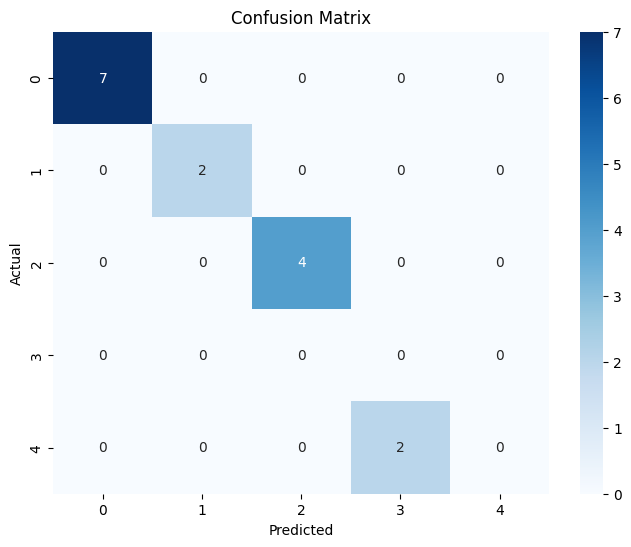

Precision: 1.0
Recall: 0.8666666666666667
F1 Score: 0.8666666666666667


In [40]:

# Convert predictions to Pandas DataFrame for using sklearn metrics
predictions_df = predictions.select("label", "prediction").toPandas()

# Plotting Confusion Matrix
cm = confusion_matrix(predictions_df['label'], predictions_df['prediction'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(len(cm[0]))],
            yticklabels=[str(i) for i in range(len(cm))])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Compute precision, recall, and F1 score for each class, handling undefined metrics
precision = precision_score(predictions_df['label'], predictions_df['prediction'], average='weighted',zero_division=1)
recall = recall_score(predictions_df['label'], predictions_df['prediction'], average='weighted', zero_division=1)
f1 = f1_score(predictions_df['label'], predictions_df['prediction'], average='weighted', zero_division=1)


print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Random Forest Regressor to predict discount percentage on product promotion


In [41]:
#Convert to panda dataframe
promotion_df_ml = promotion_df.toPandas()

# Defining the features and target variable for prediction
target_var = 'DiscountPct'

# Indexing the list of categorical features to be predicted
categoricalCols = ['EnglishPromotionType', 'SpanishPromotionType', 'FrenchPromotionType',
                   'EnglishPromotionCategory', 'SpanishPromotionCategory', 'FrenchPromotionCategory']

# Creating StringIndexers for categorical columns
indexers = [StringIndexer(inputCol=c, outputCol=c + "_index").fit(X_class_spark) for c in categoricalCols]

# Organizing the features using VectorAssembler
assembler = VectorAssembler(inputCols=[c + "_index" for c in categoricalCols], outputCol="features")

# Creating a Pipeline to chain the indexers and the VectorAssembler
pipeline = Pipeline(stages=indexers + [assembler])

# Fit and transform the data using the Pipeline
transformed_data = pipeline.fit(X_class_spark).transform(X_class_spark)

# features_prediction should now use the indexed column 'EnglishPromotionType_index'
features_pred = ['PromotionAlternateKey', 'EnglishPromotionType_index',
                       'SpanishPromotionType_index', 'FrenchPromotionType_index',
                       'EnglishPromotionCategory_index', 'SpanishPromotionCategory_index',
                       'FrenchPromotionCategory_index', 'MinQty', 'MaxQty']

# Prepare the data for prediction and instead of just selecting columns,and  transform the data using the pipeline to create 'features' column
predict_data = pipeline.fit(transformed_data).transform(transformed_data.select(features_pred +
                                                            [target_var]))

# Split the data for prediction
(train_pred, test_pred) = predict_data.randomSplit([0.7, 0.3], seed=101)

# Using the Random Forest Regressor for prediction
predict_model = RandomForestRegressor(featuresCol="features", labelCol=target_var, seed=101)
predict_model = predict_model.fit(train_pred)

# Predictions
predictions = predict_model.transform(test_pred)

# Evaluate the model
evaluator_pred = RegressionEvaluator(labelCol=target_var, predictionCol="prediction", metricName="rmse")
rmse = evaluator_pred.evaluate(predictions)

print(f"Prediction RMSE: {rmse}")

# MAE (Mean Absolute Error)
mae = RegressionEvaluator(labelCol=target_var, predictionCol="prediction", metricName="mae").evaluate(predictions)
print(f"Prediction MAE: {mae}")

# R2 (R-squared)
r2 = RegressionEvaluator(labelCol=target_var, predictionCol="prediction", metricName="r2").evaluate(predictions)
print(f"Prediction R2: {r2}")

Prediction RMSE: 0.060607912485850776
Prediction MAE: 0.0534526507936508
Prediction R2: 0.8686515816579011


In [139]:
#Showing the summary statistic for  percentage discount
promotion_df_ml['DiscountPct'].describe()

,DiscountPct
count,16.000000
mean,0.220000
std,0.161452
min,0.000000
25%,0.100000
50%,0.175000
75%,0.350000
max,0.500000


In [42]:
#Showing the predicted percentage discount
predictions.select('PromotionAlternateKey', 'prediction').show()

+---------------------+-------------------+
|PromotionAlternateKey|         prediction|
+---------------------+-------------------+
|                    2|0.11011951876063616|
|                    2|0.11011951876063616|
|                    4|0.11011951876063616|
|                    4|0.11011951876063616|
|                    5|0.11011951876063616|
|                    5|0.11011951876063616|
|                    6|0.11011951876063616|
|                    6|0.11011951876063616|
|                    9|0.31635547619047616|
|                   10| 0.4578525000000001|
|                   10| 0.4578525000000001|
|                   12|0.31635547619047616|
|                   15|           0.428205|
|                   16|  0.332150119047619|
|                   16|  0.332150119047619|
+---------------------+-------------------+



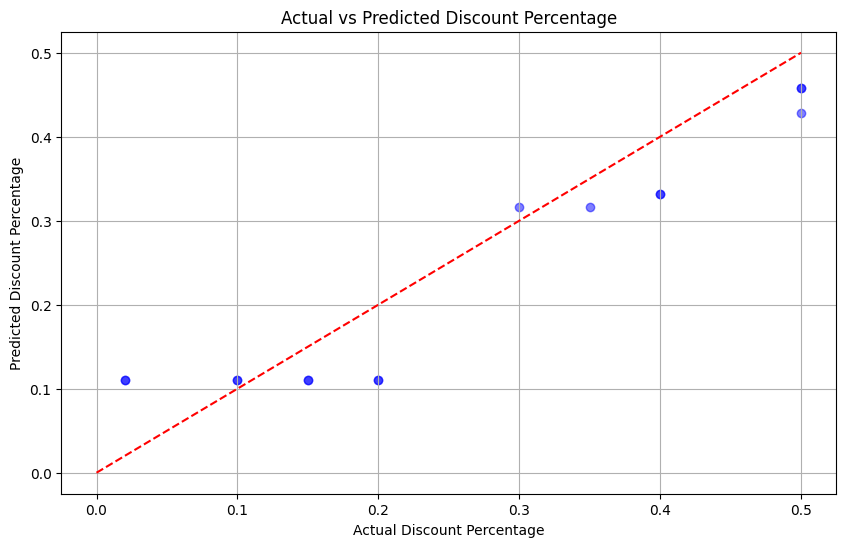

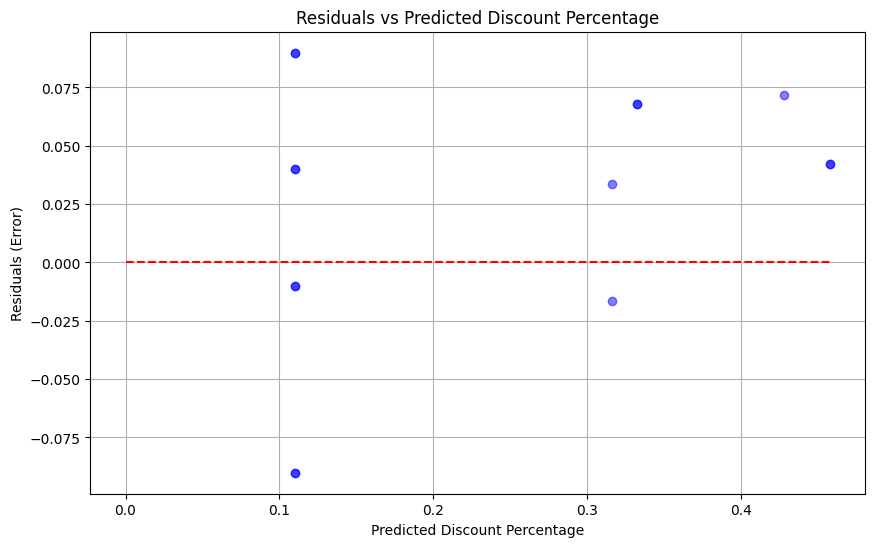

In [43]:
# Assuming 'predictions_pred' contains the predictions and actual values
actual_values = predictions.select("DiscountPct").toPandas()
predicted_values = predictions.select("prediction").toPandas()

# Plotting actual vs predicted values
plt.figure(figsize=(10,6))

# Get the maximum values from each Series using their column names
max_actual = actual_values['DiscountPct'].max()
max_predicted = predicted_values['prediction'].max()

# Use the maximum values for plotting
plt.scatter(actual_values, predicted_values, color='blue', alpha=0.5)
plt.plot([0, max(max_actual, max_predicted)],
         [0, max(max_actual, max_predicted)], color='red', linestyle='--')

plt.title('Actual vs Predicted Discount Percentage')
plt.xlabel('Actual Discount Percentage')
plt.ylabel('Predicted Discount Percentage')
plt.grid(True)
plt.show()

# Plotting residuals (errors)
residuals = actual_values['DiscountPct'] - predicted_values['prediction']
plt.figure(figsize=(10,6))
plt.scatter(predicted_values, residuals, color='blue', alpha=0.5)
plt.hlines(y=0, xmin=0, xmax=max(predicted_values['prediction'].max(), residuals.max()), colors='red', linestyle='--') # Use column name
plt.title('Residuals vs Predicted Discount Percentage')
plt.xlabel('Predicted Discount Percentage')
plt.ylabel('Residuals (Error)')
plt.grid(True)
plt.show()